# ANALYTICAL FINANCE 2
## Project : Use data for SOFR on FRED to bootstrap a SOFR Swap-curve using Python.

This project aims to bootstrap a SOFR Swap-curve using using Python.

In [1]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

In [2]:
API_KEY = pd.read_csv('.API_KEY.txt',sep=';', header=None)[1][0]
BASE_URL = 'https://api.stlouisfed.org/fred/series/observations' # END POINT FOR API

series_ids_bootstrap = {'SOFRINDEX': 'SOFR Index accumulated',
                        'SOFR': 'SOFR Index',
                        'FEDFUNDS': 'Effective Federal Funds Rate',
                        'BC_3MONTH': '3-Month Treasury Bill: Secondary Market Rate',
                        'BC_6MONTH': '6-Month Treasury Bill: Secondary Market Rate',
                        'BC_1MONTH': '1-Month Treasury Bill: Secondary Market Rate',
                        'BC_1YEAR': '1-Year Treasury Bill: Secondary Market Rate', 
}

def fetch_data(series_id):
    params = {
        'series_id': series_id,
        'api_key': API_KEY,
        'file_type': 'json',
        'frequency': 'd',  # daily frequency
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Series {series_id} not available at daily frequency, trying monthly")
        # Change frequency to monthly if daily data is not available for the series
        params = {
        'series_id': series_id,
        'api_key': API_KEY,
        'file_type': 'json',
        'frequency': 'm',  # monthly frequency
        }
        response = requests.get(BASE_URL, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error fetching {series_id}: {response.status_code}")
        return None

# Fetch data for each indicator and store in a dictionary
data = {name: fetch_data(series_id) for series_id, name in series_ids_bootstrap.items()}

# Print the fetched data keys for quick inspection
for name, content in data.items():
    if content:
        print(f"{name} retrieved")  
    else:
        print(f"{name}: No data retrieved")


# Function to convert the fetched data into a DataFrame
def convert_to_df(content):
    if content:
        try:
            df = pd.DataFrame(content['observations'])
            df['date'] = pd.to_datetime(df['date'])
            df['value'].replace('.', np.nan, inplace=True)
            df['value'] = pd.to_numeric(df['value'])
            df = df.set_index('date')
            return df
        except Exception as e:
            print(f"Error converting to DataFrame: {e}")
            return None
    else:
        return None
    
# Convert the fetched data into DataFrames
dfs = {name: convert_to_df(content) for name, content in data.items()}

dfs = {name: content for name, content in dfs.items() if content is not None}

# correlation matrix
fic_data = []
fic_data.extend(df.value for df in dfs.values())
fic_data = pd.concat(fic_data, axis=1)
fic_data.columns = dfs.keys()
fic_data.ffill(inplace=True)
fic_data.dropna(inplace=True)

fic_data['d_o_n'] = fic_data.index.dayofweek == 4
fic_data['d_o_n'] = fic_data['d_o_n'].astype(int)
#replace Friday with 3 and other days with 1
fic_data['d_o_n'] = fic_data['d_o_n'].replace(1, 3)
fic_data.loc[fic_data['d_o_n'] == 0, 'd_o_n'] = 1
fic_data

Series FEDFUNDS not available at daily frequency, trying monthly
Series BC_3MONTH not available at daily frequency, trying monthly
Error fetching BC_3MONTH: 400
Series BC_6MONTH not available at daily frequency, trying monthly
Error fetching BC_6MONTH: 400
Series BC_1MONTH not available at daily frequency, trying monthly
Error fetching BC_1MONTH: 400
Series BC_1YEAR not available at daily frequency, trying monthly
Error fetching BC_1YEAR: 400
SOFR Index accumulated retrieved
SOFR Index retrieved
Effective Federal Funds Rate retrieved
3-Month Treasury Bill: Secondary Market Rate: No data retrieved
6-Month Treasury Bill: Secondary Market Rate: No data retrieved
1-Month Treasury Bill: Secondary Market Rate: No data retrieved
1-Year Treasury Bill: Secondary Market Rate: No data retrieved


,SOFR Index accumulated,SOFR Index,Effective Federal Funds Rate,d_o_n
date,,,,
2018-04-03,1.000050,1.83,1.69,1
2018-04-04,1.000101,1.74,1.69,1
2018-04-05,1.000149,1.75,1.69,1
2018-04-06,1.000198,1.75,1.69,3
2018-04-09,1.000344,1.75,1.69,1
...,...,...,...,...
2024-10-07,1.161970,4.83,5.13,1
2024-10-08,1.162126,4.84,5.13,1
2024-10-09,1.162282,4.83,5.13,1


In [3]:
yield_curve_rate = pd.read_csv('data/yield-curve-rates-1990-2023.csv', sep=',')
yield_curve_rate['Date'] = pd.to_datetime(yield_curve_rate['Date'])
yield_curve_rate.set_index('Date', inplace=True)
yield_curve_rate.sort_index(inplace=True)

fic_data = pd.merge(fic_data, yield_curve_rate, left_index=True, right_index=True, how='inner')

In [4]:
def compute_d_o_n(r, day):
    return 1 / (1 + r * day / 360)

def compute_z_o_n(D, day):
    return -100 * np.log(D)/(day/365)

def compute_d_t_n(D_o_n, r_t_n, day):
    return D_o_n / (1+r_t_n*day/360)

def compute_z_t_n(D_t_n, day):
    return -100 * np.log(D_t_n)/(day/365)

def compute_d_i(D_t_n, r_i, day):
    return D_t_n / (1+r_i*day/360)

def compute_z_i(D_i, day):
    return -100 * np.log(D_i)/(day/365)


fic_data['D_O/N'] = fic_data.apply(lambda x: compute_d_o_n(x['SOFR Index']/100, x['d_o_n']), axis=1)
fic_data['Z_O/N'] = fic_data.apply(lambda x: compute_z_o_n(x['D_O/N'], x['d_o_n']), axis=1)
fic_data['D_T/N'] = fic_data.apply(lambda x: compute_d_t_n(x['D_O/N'], x['Effective Federal Funds Rate']/100, x['d_o_n']), axis=1)
fic_data['Z_T/N'] = fic_data.apply(lambda x: compute_z_t_n(x['D_T/N'], x['d_o_n']), axis=1)

fic_data['D_1 Mo'] = fic_data.apply(lambda x: compute_d_i(x['D_T/N'], x['1 Mo']/100, 30), axis=1)
fic_data['Z_1 Mo'] = fic_data.apply(lambda x: compute_z_i(x['D_1 Mo'], 30), axis=1)

fic_data['D_2 Mo'] = fic_data.apply(lambda x: compute_d_i(x['D_T/N'], x['2 Mo']/100, 60), axis=1)
fic_data['Z_2 Mo'] = fic_data.apply(lambda x: compute_z_i(x['D_2 Mo'], 60), axis=1)

fic_data['D_3 Mo'] = fic_data.apply(lambda x: compute_d_i(x['D_T/N'], x['3 Mo']/100, 90), axis=1)
fic_data['Z_3 Mo'] = fic_data.apply(lambda x: compute_z_i(x['D_3 Mo'], 90), axis=1)



In [16]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd

# Your data input, replace with actual data
data = {
    'SOFR Index': [0.0001, 0.0002, 0.0003],  # Daily SOFR Index
    '1 Mo': [0.001, 0.002, 0.0025],  # 1 Month rates
    '2 Mo': [0.0015, 0.0025, 0.003],  # 2 Month rates
    '3 Mo': [0.002, 0.003, 0.0035],  # 3 Month rates
    '4 Mo': [0.0022, 0.0032, 0.0037],  # 4 Month rates
    '6 Mo': [0.0025, 0.004, 0.0045],  # 6 Month rates
    '1 Yr': [0.003, 0.005, 0.0055],  # 1 Year rates
    '2 Yr': [0.004, 0.006, 0.0065],  # 2 Year rates
    '3 Yr': [0.005, 0.007, 0.0075],  # 3 Year rates
    '5 Yr': [0.006, 0.008, 0.0085],  # 5 Year rates
    '7 Yr': [0.007, 0.009, 0.0095],  # 7 Year rates
    '10 Yr': [0.008, 0.01, 0.0105],  # 10 Year rates
    '20 Yr': [0.009, 0.011, 0.0115],  # 20 Year rates
    '30 Yr': [0.01, 0.012, 0.0125],  # 30 Year rates
    # Add more maturities as needed
}
df = pd.DataFrame(data)

# Maturities in years (adjust as needed)
maturities = {
    'SOFR Index': 1/365,  # Daily SOFR Index
    '1 Mo': 1/12,  # 1 month in years
    '2 Mo': 2/12,  # 2 months in years
    '3 Mo': 3/12,  # 3 months in years
    '4 Mo': 4/12,  # 4 months in years
    '6 Mo': 6/12,  # 6 months in years
    '1 Yr': 1,     # 1 year
    '2 Yr': 2,     # 2 years
    '3 Yr': 3,     # 3 years
    '5 Yr': 5,     # 5 years
    '7 Yr': 7,     # 7 years
    '10 Yr': 10,   # 10 years
    '20 Yr': 20,   # 20 years
    '30 Yr': 30,   # 30 years
    # Add more maturities as needed
}

# Function to calculate discount factor from forward rate
def discount_factor(fwd_rate, time_period):
    return 1 / (1 + fwd_rate * time_period)

# Function to solve for discount factors using fsolve
def bootstrap_sofr_curve(df, maturities):
    discount_factors = []
    
    # Use known rates for short-term maturities to calculate discount factors directly
    for maturity, time in maturities.items():
        if time <= 1:  # Shorter maturities (e.g., up to 1 year)
            df.loc[:, f'D_{maturity}'] = 1 / (1 + df[maturity] * time)
            discount_factors.append(df[f'D_{maturity}'].mean())

    # Function to calculate discount factors for longer maturities
    def solve_discount_factor(new_discount, known_discounts, time, swap_rate):
        fixed_leg = sum(known_discounts)  # Sum of known discount factors (fixed leg)
        floating_leg = swap_rate * time * new_discount  # Floating leg, we solve for new_discount
        return floating_leg - fixed_leg  # Return the difference, should converge to 0

    # Bootstrapping for longer maturities
    for maturity, time in maturities.items():
        if time > 1:  # For maturities longer than 1 year
            swap_rate = df[maturity].mean()  # Use mean of the rates for simplicity, adjust as needed
            known_discounts = discount_factors  # Pass all known discount factors
            new_discount = fsolve(solve_discount_factor, x0=0.99, args=(known_discounts, time, swap_rate))[0]
            df.loc[:, f'D_{maturity}'] = new_discount
            discount_factors.append(new_discount)  # Add the newly solved discount factor

    return df, discount_factors

# Bootstrapping the discount factors
df, discount_factors = bootstrap_sofr_curve(fic_data[list(data.keys())], maturities)

# Zero rate calculation
def calculate_zero_rates(df, maturities):
    zero_rates = {}
    for maturity, time in maturities.items():
        df.loc[:, f'Z_{maturity}'] = -np.log(df[f'D_{maturity}']) / time
        zero_rates[maturity] = df[f'Z_{maturity}']
    return df, zero_rates

# Calculate zero rates
df, zero_rates = calculate_zero_rates(df, maturities)


C:\Users\vince\AppData\Local\Temp\ipykernel_42608\209078954.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'D_{maturity}'] = 1 / (1 + df[maturity] * time)
C:\Users\vince\AppData\Local\Temp\ipykernel_42608\209078954.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'D_{maturity}'] = 1 / (1 + df[maturity] * time)
C:\Users\vince\AppData\Local\Temp\ipykernel_42608\209078954.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [6]:
df.drop(columns=list(data.keys())).tail()

,D_SOFR Index,D_1 Mo,D_2 Mo,D_3 Mo,D_4 Mo,D_6 Mo,D_1 Yr,D_2 Yr,D_3 Yr,D_5 Yr,...,Z_4 Mo,Z_6 Mo,Z_1 Yr,Z_2 Yr,Z_3 Yr,Z_5 Yr,Z_7 Yr,Z_10 Yr,Z_20 Yr,Z_30 Yr
2023-12-22,0.985634,0.684151,0.520833,0.423729,0.355030,0.273598,0.171821,1.14637,0.941713,0.638038,...,3.106662,2.592192,1.761300,-0.0683,0.020018,0.089871,0.107037,0.107779,0.093251,0.075448
2023-12-26,0.985554,0.684541,0.520833,0.423280,0.355450,0.274725,0.171527,1.14637,0.941713,0.638038,...,3.103110,2.583967,1.763017,-0.0683,0.020018,0.089871,0.107037,0.107779,0.093251,0.075448
2023-12-27,0.985448,0.683761,0.520382,0.423729,0.356295,0.275482,0.172712,1.14637,0.941713,0.638038,...,3.095993,2.578465,1.756132,-0.0683,0.020018,0.089871,0.107037,0.107779,0.093251,0.075448
2023-12-28,0.985421,0.682982,0.519481,0.423280,0.356295,0.274725,0.171821,1.14637,0.941713,0.638038,...,3.095993,2.583967,1.761300,-0.0683,0.020018,0.089871,0.107037,0.107779,0.093251,0.075448
2023-12-29,0.985474,0.681818,0.517688,0.425532,0.356718,0.275482,0.172712,1.14637,0.941713,0.638038,...,3.092428,2.578465,1.756132,-0.0683,0.020018,0.089871,0.107037,0.107779,0.093251,0.075448


In [18]:
fic_data[data.keys()]

,SOFR Index,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
2018-04-03,1.83,1.70,NaN,1.75,NaN,1.92,2.09,2.28,2.41,2.60,2.73,2.79,2.90,3.02
2018-04-04,1.74,1.67,NaN,1.71,NaN,1.90,2.07,2.28,2.42,2.61,2.73,2.79,2.91,3.03
2018-04-05,1.75,1.67,NaN,1.72,NaN,1.93,2.07,2.30,2.45,2.64,2.76,2.83,2.95,3.07
2018-04-06,1.75,1.68,NaN,1.73,NaN,1.91,2.06,2.27,2.40,2.58,2.70,2.77,2.89,3.01
2018-04-09,1.75,1.67,NaN,1.76,NaN,1.93,2.08,2.29,2.43,2.60,2.72,2.78,2.89,3.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,5.32,5.54,5.52,5.44,5.45,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05
2023-12-26,5.35,5.53,5.52,5.45,5.44,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
2023-12-27,5.39,5.55,5.53,5.44,5.42,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95
2023-12-28,5.40,5.57,5.55,5.45,5.42,5.28,4.82,4.26,4.02,3.83,3.84,3.84,4.14,3.98


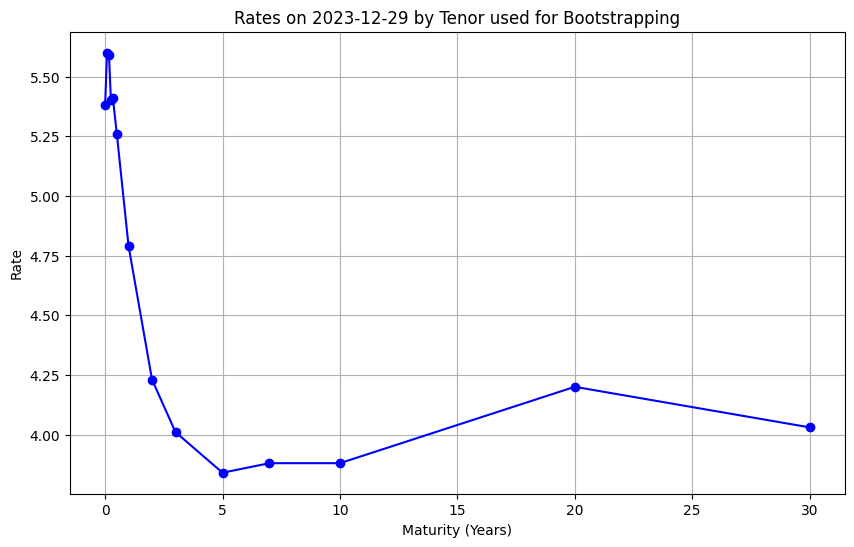

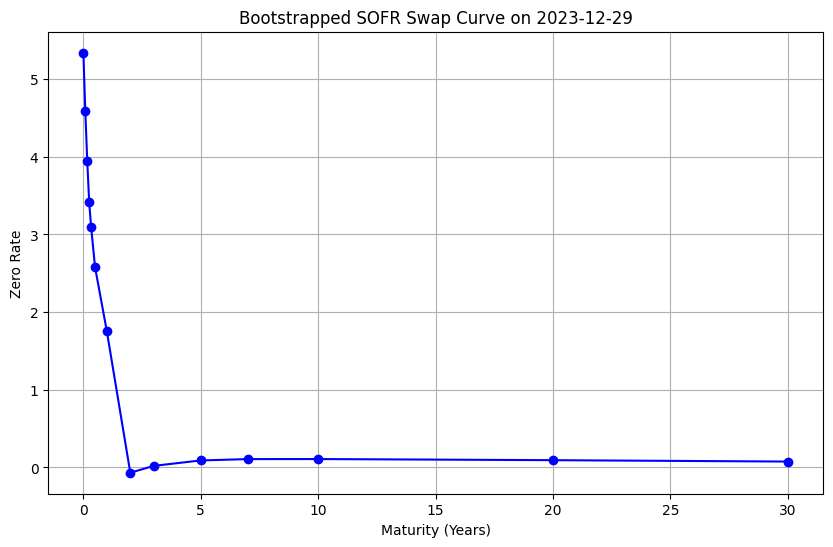

In [25]:
# Plotting the bootstrapped swap curve (zero rates) for a specific date
def plot_swap_curve(df, maturities, date):
    # Extract the zero rates for the specified date
    maturities_list = list(maturities.values())
    zero_rates_list = [df.loc[date, f'Z_{maturity}'] for maturity in maturities.keys()]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(maturities_list, zero_rates_list, marker='o', linestyle='-', color='b')
    plt.title(f'Bootstrapped SOFR Swap Curve on {date}')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Zero Rate')
    plt.grid(True)
    plt.show()


def plot_tenor(df, maturities, date):
    # Extract the zero rates for the specified date
    maturities_list = list(maturities.values())
    rate_list = [df.loc[date, maturity] for maturity in maturities.keys()]

    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(maturities_list, rate_list, marker='o', linestyle='-', color='b')
    plt.title(f'Rates on {date} by Tenor used for Bootstrapping')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Rate')
    plt.grid(True)
    plt.show()

plot_tenor(fic_data[data.keys()], maturities, '2023-12-29')
plot_swap_curve(df, maturities, date='2023-12-29')

In [40]:
def animate_data(data, maturities, title, xlabel, ylabel, interval=1000, blit=True, save=False, filename='animation.gif', fps=24):
    import matplotlib.animation as animation

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    
    line, = ax.plot([], [], marker='o', linestyle='-', color='b')
    ax.set_xlim(0, max(maturities.values()))
    ax.set_ylim(-0.1, max(data.max().max(), 0.1))
    
    def update(frame):
        date = data.index[frame]
        data_list = list(data.loc[data.index==date].values)
        maturities_list = list(maturities.values())
        line.set_data(maturities_list, data_list)
        ax.set_title(f'{title} on {date.date()}')
        return line,
    
    ani = animation.FuncAnimation(fig, update, frames=len(data.index), interval=interval, blit=blit)
    progress_callback = lambda i, n: print(f'Saving frame {i}/{n}')
    if save:
        ani.save(filename, progress_callback=progress_callback, fps=24)
    plt.show()
    plt.close(fig)

MovieWriter ffmpeg unavailable; using Pillow instead.


Saving frame 0/1438
Saving frame 1/1438
Saving frame 2/1438
Saving frame 3/1438
Saving frame 4/1438
Saving frame 5/1438
Saving frame 6/1438
Saving frame 7/1438
Saving frame 8/1438
Saving frame 9/1438
Saving frame 10/1438
Saving frame 11/1438
Saving frame 12/1438
Saving frame 13/1438
Saving frame 14/1438
Saving frame 15/1438
Saving frame 16/1438
Saving frame 17/1438
Saving frame 18/1438
Saving frame 19/1438
Saving frame 20/1438
Saving frame 21/1438
Saving frame 22/1438
Saving frame 23/1438
Saving frame 24/1438
Saving frame 25/1438
Saving frame 26/1438
Saving frame 27/1438
Saving frame 28/1438
Saving frame 29/1438
Saving frame 30/1438
Saving frame 31/1438
Saving frame 32/1438
Saving frame 33/1438
Saving frame 34/1438
Saving frame 35/1438
Saving frame 36/1438
Saving frame 37/1438
Saving frame 38/1438
Saving frame 39/1438
Saving frame 40/1438
Saving frame 41/1438
Saving frame 42/1438
Saving frame 43/1438
Saving frame 44/1438
Saving frame 45/1438
Saving frame 46/1438
Saving frame 47/1438
Sa

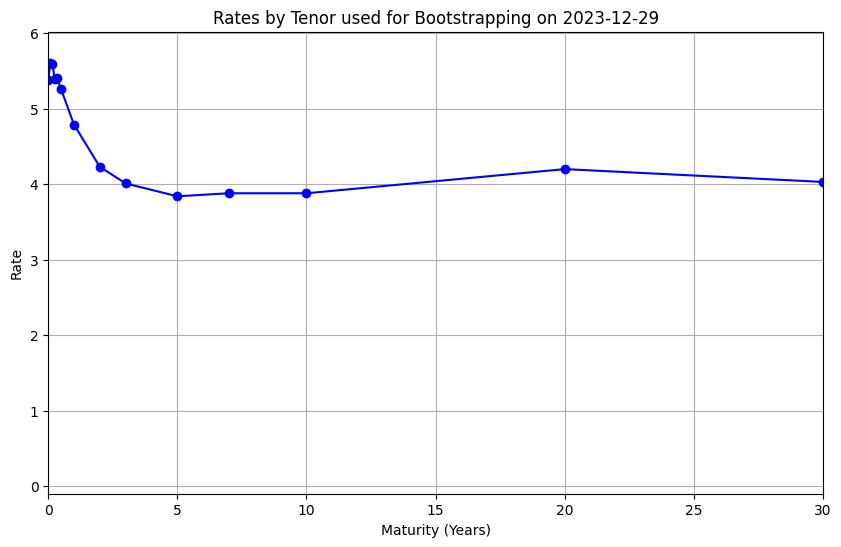

In [41]:
animate_data(fic_data[data.keys()], maturities, 
             title='Rates by Tenor used for Bootstrapping', 
             xlabel='Maturity (Years)', ylabel='Rate', 
             save=True, 
             filename='rates_by_tenor.gif')

In [27]:
import matplotlib.animation as animation
from IPython import display 

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the title, labels, and grid
ax.set_title('Bootstrapped SOFR Swap Curve')
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Zero Rate')
ax.grid(True)

# Line object for the plot that will be updated
line, = ax.plot([], [], marker='o', linestyle='-', color='b')

# Limits for the axes (adjust based on your data)
ax.set_xlim(0, max(maturities.values()))  # Set x-axis (maturity) limits
ax.set_ylim(-0.1, max(df[f'Z_{list(maturities.keys())[0]}']) + 0.1)  # Set y-axis (zero rate) limits

# Animation function to update the plot for each date
def update(frame):
    date = df.index[frame]  # Get the current date
    zero_rates_list = [df.loc[date, f'Z_{maturity}'] for maturity in maturities.keys()]
    maturities_list = list(maturities.values())
    
    # Update the line data
    line.set_data(maturities_list, zero_rates_list)
    
    # Update the title to show the current date
    ax.set_title(f'Bootstrapped SOFR Swap Curve on {date.date()}')
    
    return line,

# Create the animation and assign it to a persistent variable
ani = FuncAnimation(fig, update, frames=len(df.index), interval=1000, blit=True)

# # Display the animation in a Jupyter notebook or save it
progress_callback = lambda i, n: print(f'Saving frame {i}/{n}')
ani.save('sofr_swap_curve_animation.gif', writer='mencoder', progress_callback=progress_callback, fps=24)  # Save as mp4 (requires ffmpeg)
plt.show()  # Display the animation

TypeError: animate_data() got an unexpected keyword argument 'progress_callback'